In [1]:
from astropy.io import fits
# Open the FITS file
filename = 'ni6203980138_0mpu7_cl.evt'
with fits.open(filename) as hdul:
    # Get the primary HDU (Header Data Unit)
    header = hdul[0].header

    # Print the header
    print(repr(header))

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
TELESCOP= 'NICER   '           / Telescope (mission) name                       
INSTRUME= 'XTI     '           / Instrument name                                
TARG_ID =                 5394 / NICER target catalog ID number                 
OBSERVER= 'GENDREAU, KEITH C.' / Observer or Principal Investigator             
TITLE   = ''                   / Science program title                          
OBS_ID  = '6203980138'         / Observation ID                                 
ORIGIN  = 'NASA/GSFC'       

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import black
# Uncomment and run this before releasing a new version of the docs
# import jupyter_black

# jupyter_black.load(
#     lab=False,
#     line_length=100,
#     verbosity="DEBUG",
#     target_version=black.TargetVersion.PY310,
# )

import copy
import glob
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.modeling import models

from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList
from stingray.modeling.parameterestimation import PSDLogLikelihood

## Data loading and cleanup

In [3]:
# Here we are also saving the information about the detector
events = EventList.read(filename, "hea", additional_columns=["DET_ID"])
events.fname = filename

<Axes: xlabel='Time (s)', ylabel='counts'>

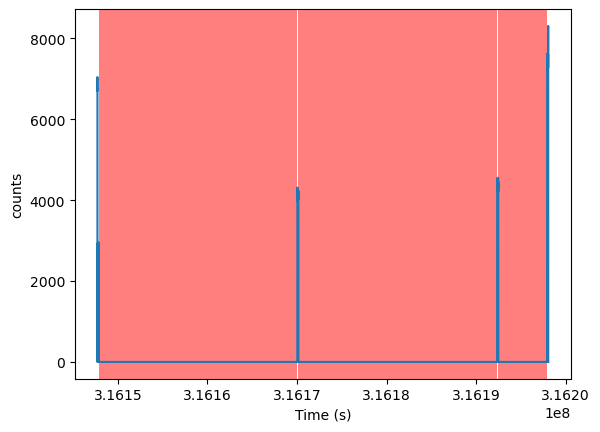

In [5]:
# Create light curve and apply GTIs
lc_raw = events.to_lc(dt=1)

lc_raw.plot()

<Axes: xlabel='Time (s)', ylabel='counts'>

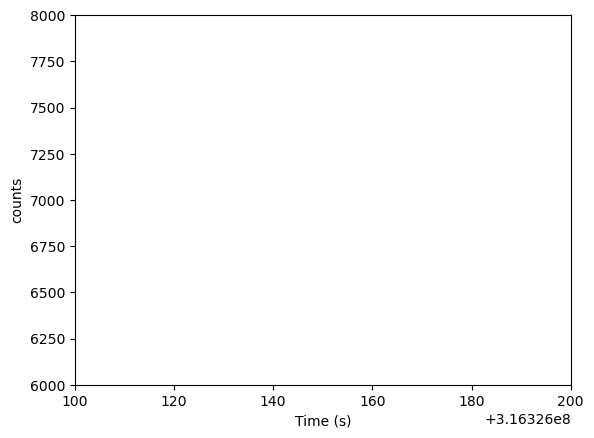

In [10]:
# lc_raw.plot(axis_limits=[3.1632e8+6100, 3.1632e8+6200, 6000, 8000])

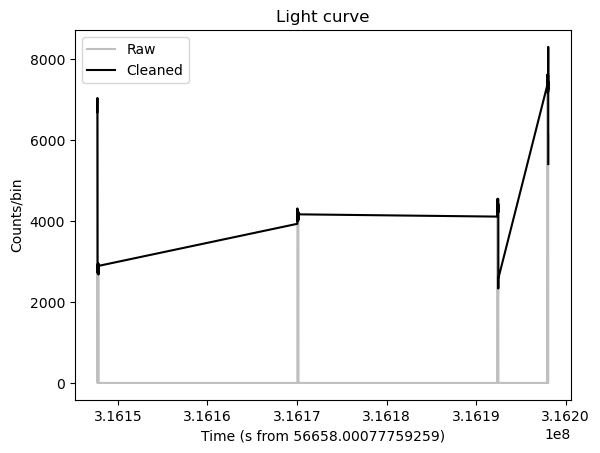

In [6]:
new_gti = create_gti_from_condition(lc_raw.time, lc_raw.counts > 0, safe_interval=1)
lc = copy.deepcopy(lc_raw)
lc.gti = new_gti
lc.apply_gtis()

plt.figure()
plt.plot(lc_raw.time, lc_raw.counts, color="grey", alpha=0.5, label="Raw")
plt.plot(lc.time, lc.counts, color="k", label="Cleaned")
plt.title("Light curve")
plt.xlabel(f"Time (s from {events.mjdref})")
plt.ylabel(f"Counts/bin")
plt.legend();

events.gti = new_gti

Total exposure: 515.0
Total BTI length: 49812.0
Total BTI length (short BTIs): 0.0


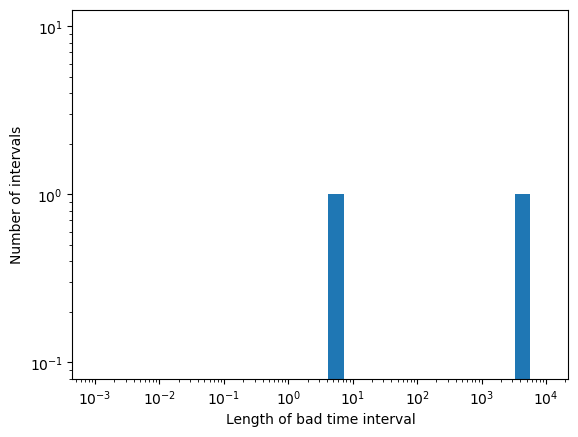

In [7]:
from stingray.gti import get_gti_lengths, get_btis, get_total_gti_length
# 统计bti
gti_lengths = get_gti_lengths(events.gti)
btis = get_btis(events.gti)
bti_lengths = get_gti_lengths(btis)

plt.hist(bti_lengths, bins=np.geomspace(1e-3, 10000, 30))
plt.xlabel("Length of bad time interval")
plt.ylabel("Number of intervals")
plt.loglog()

print(f"Total exposure: {get_total_gti_length(events.gti)}")
print(f"Total BTI length: {get_total_gti_length(btis)}")
print(f"Total BTI length (short BTIs): {get_total_gti_length(btis[bti_lengths < 1])}")

<Axes: xlabel='Time (s)', ylabel='counts'>

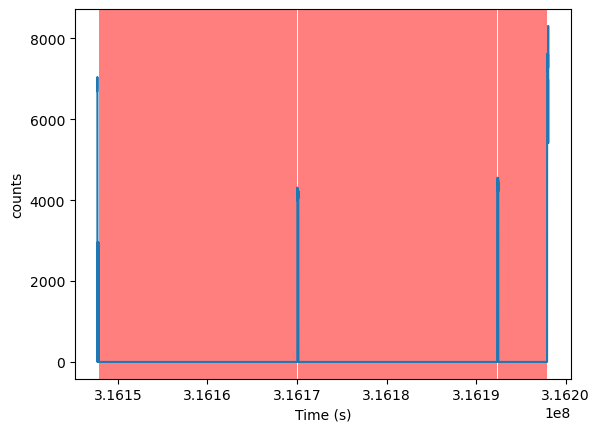

In [8]:
# max_length is the longest bad time interval in seconds we want to fill with simulated data.
# The buffer size is the region (in seconds) around the bad time interval that we use to
# extract the distribution of the data to simulate
# 使用模拟数据填充短的bti
ev_filled = events.fill_bad_time_intervals(max_length=1, buffer_size=4)
lc_filled = ev_filled.to_lc(dt=1)
lc_filled.plot()


In [9]:
events = ev_filled

In [10]:
ndet = len(set(events.det_id))
print(f"NICER was using {ndet} detectors")

NICER was using 39 detectors


In [12]:
# Using the same intervals as the Wang+ paper.
# We use a segment size of 256 seconds, but we could make different choices depending
# on the quality of the dataset and the count rate.

h_starts, h_stops, colors, color_errs = events.get_color_evolution(
    energy_ranges=[[2, 4], [4, 12]], segment_size=64
)
i_starts, i_stops, intensity, intensity_errs = events.get_intensity_evolution(
    energy_range=[0.4, 12], segment_size=64
)

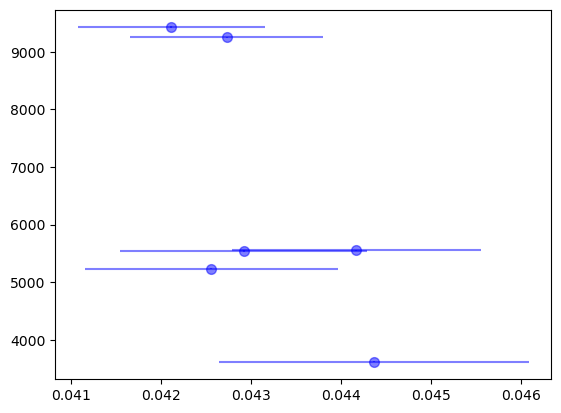

In [13]:
fig, ax = plt.subplots()
(plotline, _, _) = ax.errorbar(
    colors,
    intensity / ndet * 50,
    yerr=intensity_errs / ndet * 50,
    xerr=color_errs,
    fmt="o",
    color="b",
    alpha=0.5,
    markersize=7,
    label="Stingray analysis",
    zorder=10,
)

## Periodogram and crosss spectrum

In [15]:
# Calculate the periodogram in fractional rms normalization.
# Length in seconds of each light curve segment
segment_size = 16
# Sampling time of the light curve: 1ms, this will give a Nyquist
# frequency of 0.5 / dt = 500 Hz.
dt = 0.0002
# Fractional rms normalization
norm = "frac"

pds = AveragedPowerspectrum.from_events(
    events, segment_size=segment_size, dt=dt, norm=norm, use_common_mean=True
)

# Calculate the mean count rate
ctrate = get_average_ctrate(events.time, events.gti, segment_size)
# Calculate the Poisson noise level
noise = poisson_level(norm, meanrate=ctrate)

# Rebin the periodogam
pds_reb = pds.rebin_log(0.02)

30it [00:00, 327.92it/s]


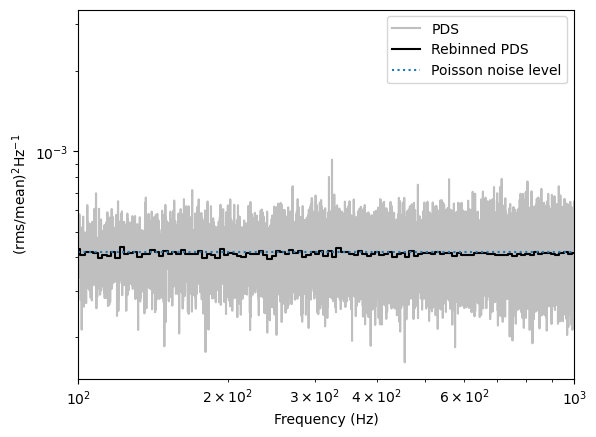

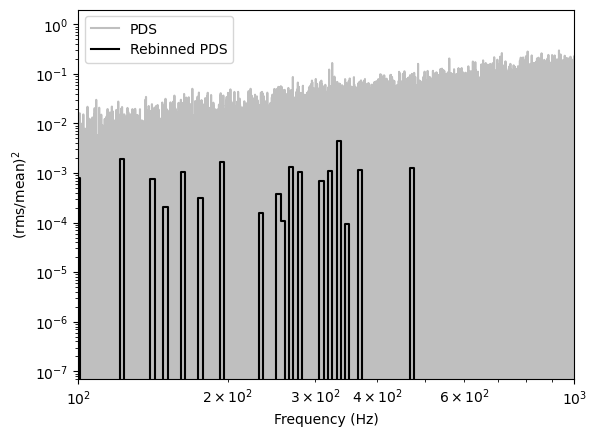

In [18]:
plt.figure()

plt.plot(pds.freq, pds.power, drawstyle="steps-mid", color="grey", alpha=0.5, label="PDS")
plt.plot(pds_reb.freq, pds_reb.power, drawstyle="steps-mid", color="k", label="Rebinned PDS")
plt.axhline(noise, ls=":", label="Poisson noise level")
plt.loglog()
plt.xlim(100,1000)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2 Hz^{-1}}$")
plt.legend()

plt.figure()
plt.plot(
    pds.freq,
    (pds.power - noise) * pds.freq,
    drawstyle="steps-mid",
    color="grey",
    alpha=0.5,
    label="PDS",
)
plt.plot(
    pds_reb.freq,
    (pds_reb.power - noise) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.xlim(100,1000)
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend();

/var/folders/l8/y44hjpdj1sv516jrp7xn86jc0000gn/T/ipykernel_47259/2307472923.py:2: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt((pds_reb.power - noise) * pds_reb.freq)  # 示例误差数据，假设是功率谱的平方根


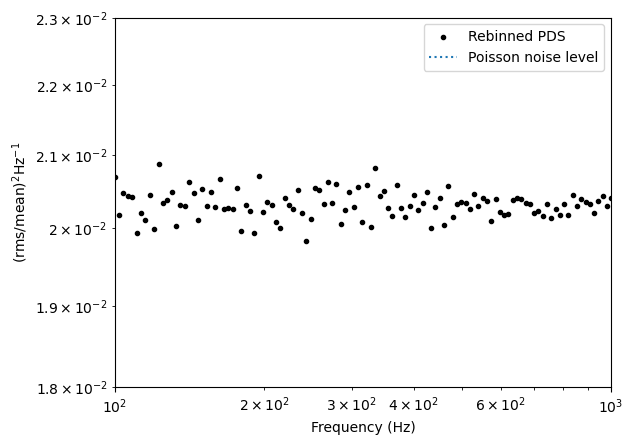

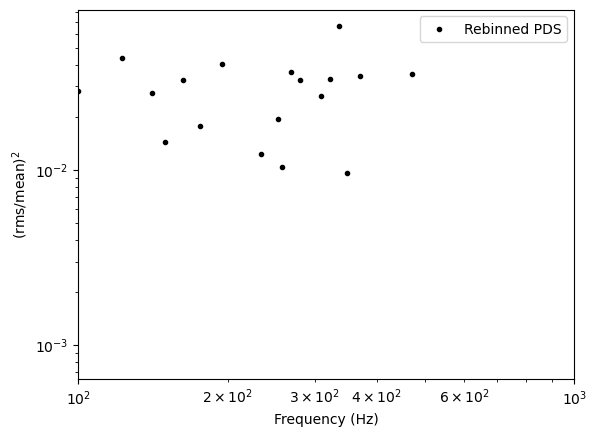

In [27]:
plt.figure()
errors = np.sqrt((pds_reb.power - noise) * pds_reb.freq)  # 示例误差数据，假设是功率谱的平方根
errors_reb = np.sqrt(pds_reb.power)  # 对重采样功率谱的误差

# plt.scatter(pds.freq, errors, color="grey", alpha=0.5, label="PDS")
plt.scatter(pds_reb.freq, errors_reb, marker='.', color="k", label="Rebinned PDS")
plt.axhline(noise, ls=":", label="Poisson noise level")
plt.loglog()
plt.xlim(100,1000)
plt.ylim(1.8e-2,2.3e-2)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2 Hz^{-1}}$")
plt.legend()

plt.figure()
plt.scatter(pds_reb.freq, errors, marker='.', color="k", label="Rebinned PDS")
plt.xlim(100,1000)
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend();

In [1]:
import sys
print(sys.executable)


/Users/songyj/anaconda3/bin/python


In [ ]:
ref_band = [1.5, 3]
sub_band = [0.5, 1]
events_ref = events.filter_energy_range(ref_band)
events_sub = events.filter_energy_range(sub_band)

cs = AveragedCrossspectrum.from_events(
    events_sub, events_ref, segment_size=segment_size, dt=dt, norm=norm
)
cs_reb = cs.rebin_log(0.02)

In [ ]:
plt.figure()
plt.plot(cs.freq, cs.power * cs.freq, drawstyle="steps-mid", color="grey", alpha=0.5)
plt.plot(cs_reb.freq, cs_reb.power * cs_reb.freq, drawstyle="steps-mid", color="k")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$");

In [ ]:
pds = AveragedPowerspectrum.from_events(events, segment_size=segment_size, dt=dt, norm="leahy")
pds_reb = pds.rebin_log(0.02)


In [ ]:
plt.figure()
plt.plot(
    pds_reb.freq,
    (pds_reb.power - 2) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.semilogx()
plt.xlim([pds.freq[0], pds.freq[-1]])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend()

## Lags and coherence

In [ ]:
# Use shorter segments, rebin a little more heavily
cs = AveragedCrossspectrum.from_events(events_sub, events_ref, segment_size=2, dt=0.005, norm=norm)
cs_reb = cs.rebin_log(0.4)

lag, lag_e = cs_reb.time_lag()

In [ ]:
plt.figure()
plt.errorbar(cs_reb.freq, lag, yerr=lag_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    f"Time lag ({ref_band[0]:g}-{ref_band[1]:g} keV vs {sub_band[0]:g}-{sub_band[1]:g} keV, in seconds)"
)
plt.axhline(0, ls="--")
plt.semilogx()

In [ ]:
coh, coh_e = cs_reb.coherence()
plt.figure()
plt.errorbar(cs_reb.freq, coh, yerr=coh_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    f"Coherence ({sub_band[0]:g}-{sub_band[1]:g} keV vs {ref_band[0]:g}-{ref_band[1]:g} keV)"
)
plt.axhline(0, ls="--")
plt.loglog()